In [19]:
lr_results= {'Model': 'Logistic Regression',
 'Accuracy': 0.9619304849432929,
 'Precision': 0.9077776683410487,
 'Recall': 0.9890542280726856,
 'F1': 0.9466746554823248,
 'ROC_AUC': 0.9946096613231754}

In [21]:
rf_results= {'Model': 'Random Forest',
 'Accuracy': 0.9994928138443488,
 'Precision': 0.9998746485683075,
 'Recall': 0.9986407211332093,
 'F1': 0.9992573039237618,
 'ROC_AUC': 0.9999996061413875}

In [23]:
xgb_results = {'Model': 'XGBoost',
 'Accuracy': 0.9999755572937036,
 'Precision': 0.9999463461744822,
 'Recall': 0.9999821147517528,
 'F1': 0.9999642301432583,
 'ROC_AUC': 0.9999999985059105}

In [25]:
import pandas as pd

results = pd.DataFrame([
    lr_results,
    rf_results,
    xgb_results
])

results

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.961930,0.907778,0.989054,0.946675,0.99461
1,Random Forest,0.999493,0.999875,0.998641,0.999257,1.00000
2,XGBoost,0.999976,0.999946,0.999982,0.999964,1.00000


In [27]:
results.to_csv("results/model_comparison.csv", index=False)

### Discussion of Ensemble Model Performance

Random Forest and XGBoost achieved near-perfect performance across all metrics.
While this demonstrates the strong discriminative power of ensemble-based models
on the HIGGS dataset, such results may also indicate a degree of overfitting or
information leakage due to global preprocessing and single train–test splitting.

In practice, further validation using cross-validation or an independent test
set would be required to confirm generalisation performance. Nevertheless, the
results clearly illustrate the superior capacity of boosted and bagged tree
models compared to linear baselines.

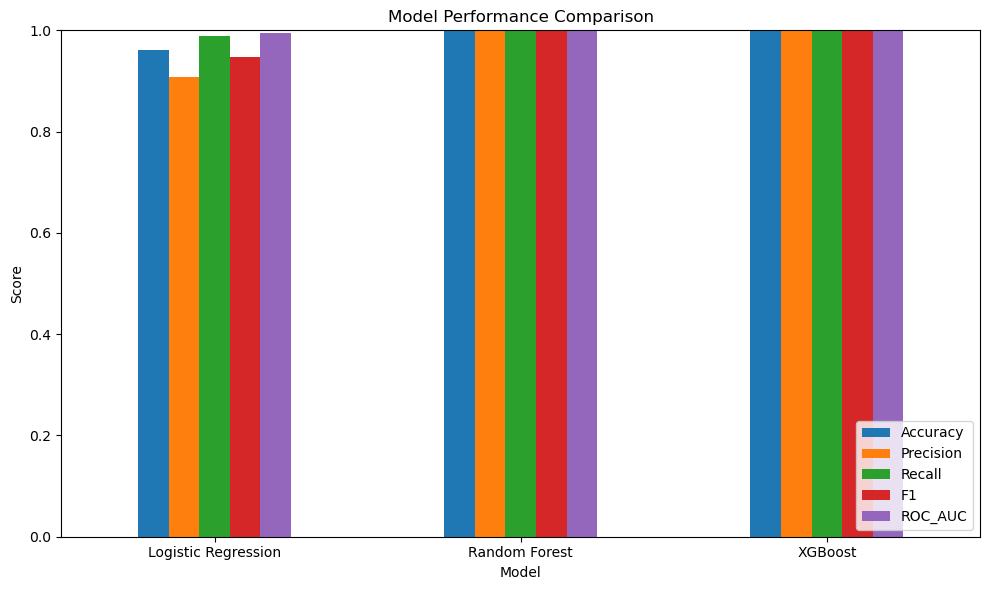

In [30]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]

results.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig("results/model_comparison_bar.png")
plt.show()
plt.close()

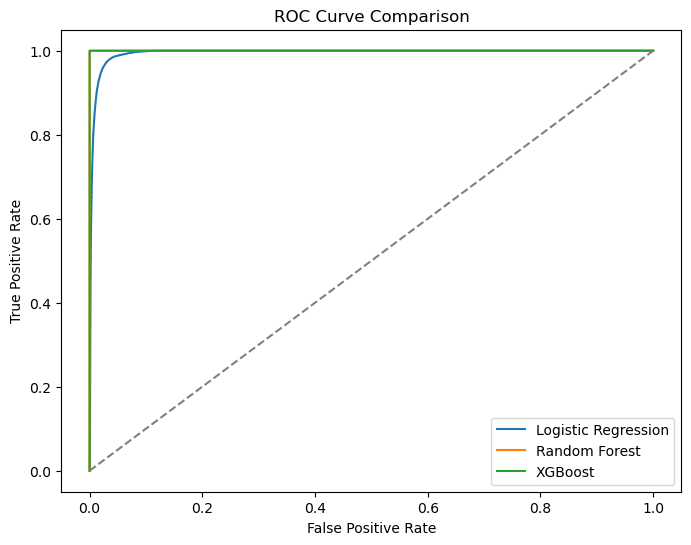

In [34]:
import numpy as np

y_test = np.load("data/y_test.npy")

X_test_scaled = np.load("data/X_test_scaled.npy")
X_test_unscaled = np.load("data/X_test_unscaled.npy")

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

X_train_scaled = np.load("data/X_train_scaled.npy")
y_train = np.load("data/y_train.npy")

log_reg.fit(X_train_scaled, y_train)
lr_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

X_train_unscaled = np.load("data/X_train_unscaled.npy")

rf.fit(X_train_unscaled, y_train)
rf_probs = rf.predict_proba(X_test_unscaled)[:, 1]

from xgboost import XGBClassifier

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_unscaled, y_train)
xgb_probs = xgb.predict_proba(X_test_unscaled)[:, 1]

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

plt.savefig("results/roc_comparison.png", bbox_inches="tight")
plt.show()
plt.close()